In [1]:
import os
from pathlib import Path

if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path.cwd().parent.resolve()

os.chdir(PROJECT_ROOT)

In [2]:
from edit_penalty import EditPenaltyCollection, EditPenaltyCollectionAnalyser
from matplotlib.figure import Figure
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import pandas as pd
from pandas import DataFrame, Series
from typing import Iterable, Literal, Tuple

plt.style.use("ggplot")
plt.style.use("my.mplstyle")

In [3]:
RESULTS_DIR = PROJECT_ROOT/"analysis_results"

LARGELY_SAMPLED_EPITOPES = (
    # "CINGVCWTV",
    "GILGFVFTL",
    # "GLCTLVAML",
    # "LLWNGPMAV",
    "NLVPMVATV",
    "SPRWYFYYL",
    "TFEYVSQPFLMDLE",
    "TTDPSFLGRY",
    "YLQPRTFLL"
)

NUM_SHOTS_OF_INTEREST = [1,2,5,10,20,50,100,200]

In [4]:
class ModelToPlot:
    def __init__(self, model_name: str, colour: str, marker: str) -> None:
        self.name = model_name
        self.colour = colour
        self.marker = marker
    
    def load_data(self, task_name: str) -> DataFrame:
        path_to_csv = RESULTS_DIR/self.name/f"{task_name}.csv"
        return pd.read_csv(path_to_csv)
    
    def load_epc_analyser(self) -> EditPenaltyCollectionAnalyser:
        path_to_epc_state_dict = RESULTS_DIR/self.name/"epc_state_dict.pkl"
        with open(path_to_epc_state_dict, "rb") as f:
            epc = EditPenaltyCollection.from_save(f)
        return EditPenaltyCollectionAnalyser(epc)

In [7]:
def plot_ovr_nn_summary_figure(models: Iterable[ModelToPlot], ks: Iterable[int], epitopes: Iterable[str]) -> Figure:    
    fig, ax = plt.subplots(figsize=(6,5))

    for model in models:
        ax.plot(get_model_ovr_nn_summary(model, ks, epitopes), model.marker, c=model.colour, label=model.name)

    ax.set_ylabel("Average AUROC")
    ax.set_xlabel("Number of Shots")
    ax.set_xticks(range(len(ks)), ks)

    ax.legend()
    fig.tight_layout()

    return fig    


def get_model_ovr_nn_summary(model: ModelToPlot, ks: Iterable[int], epitopes: Iterable[str]) -> ndarray:
    raw_results = [model.load_data(get_ovr_task_name(k)) for k in ks]
    average_auc_per_epitope = [df.groupby("epitope").aggregate({"auc": "mean"}) for df in raw_results]
    avg_aucs = [s[s.index.isin(epitopes)].mean() for s in average_auc_per_epitope]
    return np.array(avg_aucs)


def get_ovr_task_name(k: int) -> str:
    if k == 1:
        return "one_vs_rest_1_shot"
    return f"one_vs_rest_{k}_shot_nn"


def get_mean_auc_per_epitope(raw_df: DataFrame) -> DataFrame:
    return raw_df.groupby("epitope").aggregate({"auc": "mean"})


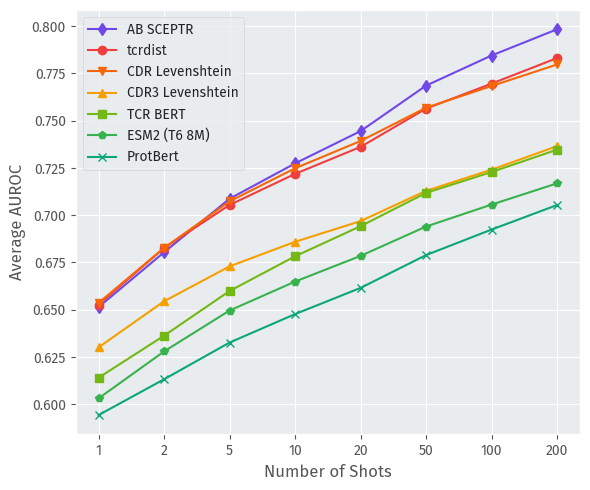

In [9]:
models = (
    ModelToPlot("AB SCEPTR", "#7048e8", "d-"),
    ModelToPlot("tcrdist", "#f03e3e", "o-"),
    ModelToPlot("CDR Levenshtein", "#f76707", "v-"),
    ModelToPlot("CDR3 Levenshtein", "#f59f00", "^-"),
    ModelToPlot("TCR BERT", "#74b816", "s-"),
    ModelToPlot("ESM2 (T6 8M)", "#37b24d", "p-"),
    ModelToPlot("ProtBert", "#0ca678", "x-"),
)

fig = plot_ovr_nn_summary_figure(models, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES)
fig.savefig("shootout.pdf")

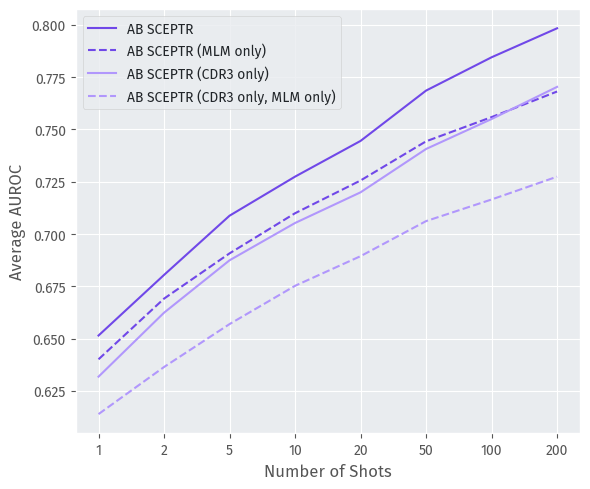

In [10]:
models = (
    ModelToPlot("AB SCEPTR", "#7048e8", "-"),
    ModelToPlot("AB SCEPTR (MLM only)", "#7048e8", "--"),
    ModelToPlot("AB SCEPTR (CDR3 only)", "#b197fc", "-"),
    ModelToPlot("AB SCEPTR (CDR3 only, MLM only)", "#b197fc", "--"),
)

fig = plot_ovr_nn_summary_figure(models, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES)
fig.savefig("ablation.pdf")

In [11]:
def plot_predetermined_split_results(models: Iterable[ModelToPlot], classification_method: Literal["nn", "avg_dist"]) -> Figure:
    aucs_per_model = [model.load_data(f"one_vs_rest_predetermined_split_{classification_method}").set_index("epitope") for model in models]
    
    for model, aucs in zip(models, aucs_per_model):
        aucs.columns = [model.name]
    
    aucs_per_model = pd.concat(aucs_per_model, axis="columns")
    aucs_per_model["avg"] = aucs_per_model.apply(lambda row: row.mean(), axis="columns")
    aucs_per_model = aucs_per_model.sort_values(by="avg", ascending=False)

    fig, ax = plt.subplots(figsize=(6,5))

    for model in models:
        ax.plot(aucs_per_model[model.name], model.marker, c=model.colour, label=model.name)

    ax.set_ylabel("AUC")
    ax.set_xlabel("Epitope")

    ax.legend()
    fig.tight_layout()

    return fig

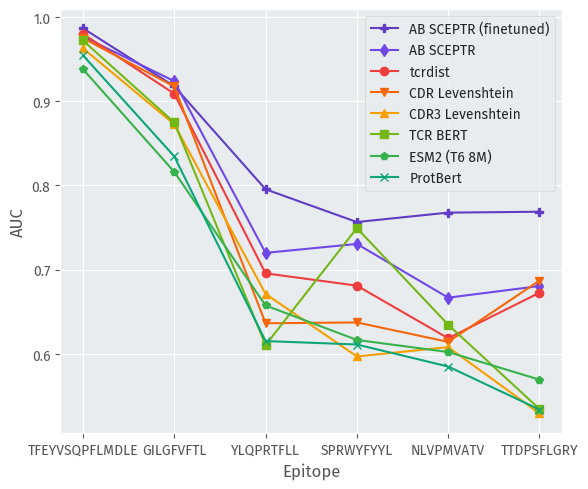

In [12]:
models = (
    ModelToPlot("AB SCEPTR (finetuned)", "#5f3dc4", "P-"),
    ModelToPlot("AB SCEPTR", "#7048e8", "d-"),
    ModelToPlot("tcrdist", "#f03e3e", "o-"),
    ModelToPlot("CDR Levenshtein", "#f76707", "v-"),
    ModelToPlot("CDR3 Levenshtein", "#f59f00", "^-"),
    ModelToPlot("TCR BERT", "#74b816", "s-"),
    ModelToPlot("ESM2 (T6 8M)", "#37b24d", "p-"),
    ModelToPlot("ProtBert", "#0ca678", "x-"),
)

fig = plot_predetermined_split_results(models, "nn")
fig.savefig("scl.pdf")

In [15]:
def plot_model_calibration() -> Figure:
    models = (
        ModelToPlot("AB SCEPTR", None, None),
        ModelToPlot("AB SCEPTR (classic)", None, None),
        ModelToPlot("TCR BERT", None, None),
    )
    epc_insights_per_model = {model.name: model.load_epc_analyser().get_summary_df() for model in models}

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=True)

    position_array = np.arange(5) * 6
    errorbar_kwargs = {
        "fmt": "-"
    }

    for ax, model_name in zip(axs, epc_insights_per_model):
        epc_insights = epc_insights_per_model[model_name]

        ax.errorbar(position_array, epc_insights["ins"], yerr=epc_insights["ins_std"], label="insertion", c="#7048e8", **errorbar_kwargs)
        ax.errorbar(position_array+1, epc_insights["del"], yerr=epc_insights["del_std"], label="deletion", c="#f76707", **errorbar_kwargs)
        ax.errorbar(position_array+2, epc_insights["sub"], yerr=epc_insights["sub_std"], label="substitution", c="#37b24d", **errorbar_kwargs)
        ax.set_xticks(
            position_array+1, epc_insights.index
        )

        ax.set_title(model_name)

    axs[0].set_ylabel("distance")
    axs[1].set_xlabel("CDR3 region")
    axs[2].legend(loc="center left", bbox_to_anchor=(1.1,0,1,1))

    fig.tight_layout()
    
    return fig

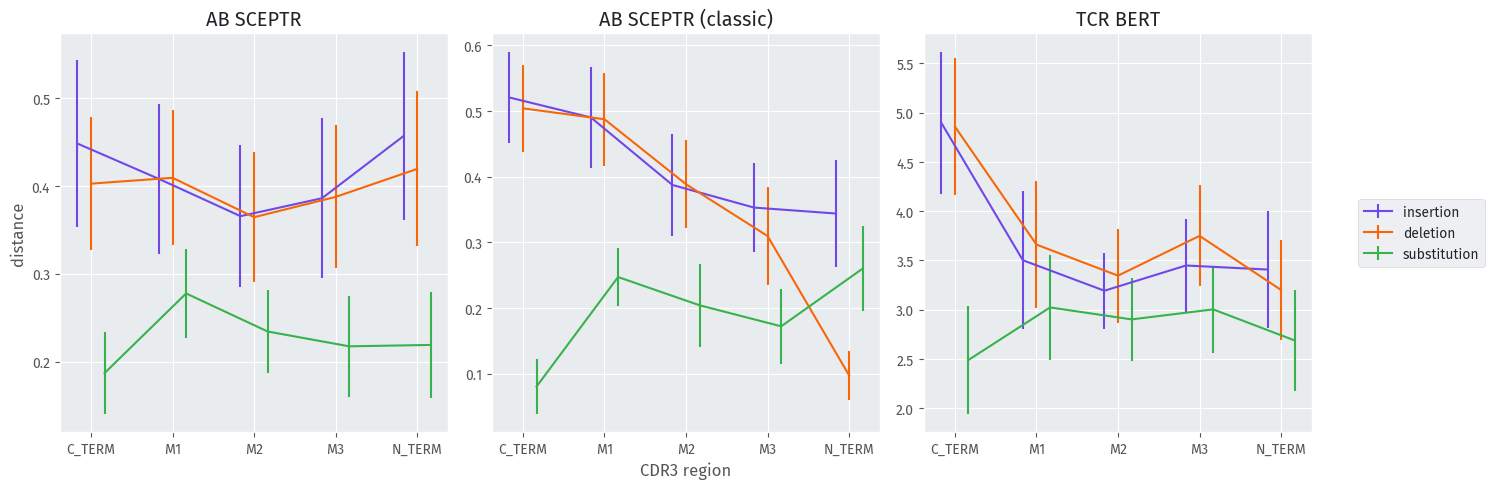

In [17]:
fig = plot_model_calibration()
fig.savefig("calibration.pdf")

In [18]:
def generate_delta_plot(anchor_model: ModelToPlot, comparison_models: Iterable[ModelToPlot], ks: Iterable[int], epitopes: Iterable[str]) -> Figure:
    fig, ax = plt.subplots(figsize=(6,5))

    for comparison_model in comparison_models:
        delta, std_delta = compute_delta_estimate_to_anchor(anchor_model, comparison_model, ks, epitopes)
        ax.errorbar(x=range(len(ks)), y=delta, yerr=std_delta, fmt=comparison_model.marker, c=comparison_model.colour, label=comparison_model.name, capsize=5)

    ax.set_ylabel(rf"$\Delta$ AUROC to {anchor_model.name}")
    ax.set_xlabel("Number of Shots")
    ax.set_xticks(range(len(ks)), ks)

    ax.legend(loc="lower left")
    fig.tight_layout()

    return fig

def compute_delta_estimate_to_anchor(anchor_model: ModelToPlot, comparison_model: ModelToPlot, ks: Iterable[int], epitopes: Iterable[str]) -> Tuple[ndarray, ndarray]:
    delta, std_delta = [], []

    for k in ks:
        anchor_results = anchor_model.load_data(get_ovr_task_name(k))
        comparison_results = comparison_model.load_data(get_ovr_task_name(k))
        comparison_results["delta"] = comparison_results["auc"] - anchor_results["auc"]
        comparison_results = comparison_results[comparison_results["epitope"].map(lambda x: x in epitopes)]
        delta_by_epitope = comparison_results.groupby("epitope").apply(
            lambda df: Series(data=(df["delta"].mean(), df["delta"].var()), index=("mean", "var")),
            include_groups=False
        )
        delta_sum, var_delta_sum = delta_by_epitope.sum()
        delta.append(delta_sum / len(delta_by_epitope))
        std_delta.append(np.sqrt(var_delta_sum) / len(delta_by_epitope))

    return np.array(delta), np.array(std_delta)

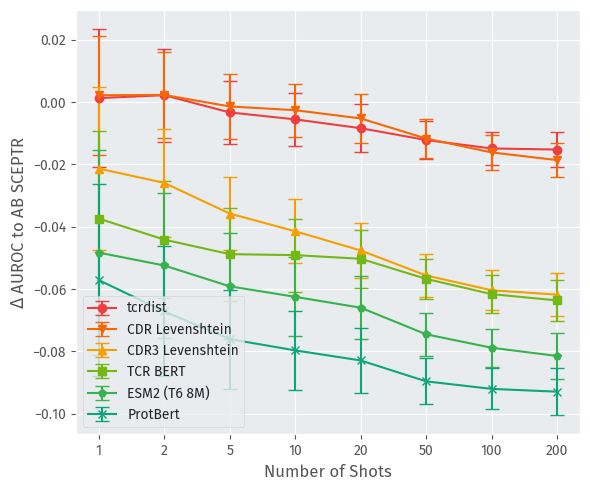

In [20]:
anchor = ModelToPlot("AB SCEPTR", "#7048e8", "d-")
comparisons = (
    ModelToPlot("tcrdist", "#f03e3e", "o-"),
    ModelToPlot("CDR Levenshtein", "#f76707", "v-"),
    ModelToPlot("CDR3 Levenshtein", "#f59f00", "^-"),
    ModelToPlot("TCR BERT", "#74b816", "s-"),
    ModelToPlot("ESM2 (T6 8M)", "#37b24d", "p-"),
    ModelToPlot("ProtBert", "#0ca678", "x-"),
)

fig = generate_delta_plot(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES)
fig.savefig("delta_auroc.pdf")

In [ ]:
def generate_pgen_density_plot(model_name: str) -> Figure:
    pgen_nn_dists = load_data(model_name, "pgen_nn_dists")
    log10_pgens = np.log10(pgen_nn_dists["pgen"])
    bins = range(-20, -14)
    bin_positions = range(len(bins) + 1)
    nn_dists_by_pgen = bin_dists_by_pgen(pgen_nn_dists["nn_dist"], log10_pgens, bins)

    fig, ax = plt.subplots()
    ax.boxplot(nn_dists_by_pgen, positions=bin_positions)

    bin_labels = ["$<10^{" + str(bins[0]) + "}$"]
    bin_labels += [
        "$10^{" + str(bins[i]) + "}-10^{" + str(bins[i + 1]) + "}$"
        for i in range(len(bins) - 1)
    ]
    bin_labels += ["$>10^{" + str(bins[-1]) + "}$"]

    ax.set_xticks(bin_positions)
    ax.set_xticklabels(bin_labels, rotation=45, ha="right")

    fig.tight_layout()

def bin_dists_by_pgen(dists, pgens, bins) -> list:
    binned_data = [[] for _ in range(len(bins) + 1)]

    inds = np.digitize(pgens, bins)
    for value, ind in zip(dists, inds):
        binned_data[ind].append(value)

    return binned_data

In [ ]:
generate_pgen_density_plot("tcrdist")

In [ ]:
generate_pgen_density_plot("AB SCEPTR")